<a href="https://colab.research.google.com/github/Bryan-PORTAILL/FCC-ML-Certification-Cat-and-Dog-Image-Classifier/blob/main/FCC%20-%20ML%20Certification%20-%20Cat%20and%20Dog%20Image%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my solution to the FreeCodeCamp Machine Learning Certification project Cat and Dog Image Classifier.

I took the liberty of modifying a few things (such as some variable names) to make the project clearer to read.

The first cell imports all the utilities we will need to create a Convolutional Neural Network able to differentiate between cat and dog pictures.

In [ ]:
# 1

import os
import matplotlib.pyplot
import numpy

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

The second cell imports our training, validation and  testing data, creates the necessary folders, and defines the project variables.

In [ ]:
# 2

!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
!unzip -q cats_and_dogs.zip

main_directory = 'cats_and_dogs'
training_directory = os.path.join(main_directory, 'train')
validation_directory = os.path.join(main_directory, 'validation')
testing_directory = os.path.join(main_directory, 'test')

total_training_images = sum([len(files) for root, directory, files in os.walk(training_directory)])
total_validation_images = sum([len(files) for root, directory, files in os.walk(validation_directory)])
total_testing_images = len(os.listdir(testing_directory))

batch_size = 30
epochs = 15
image_height = 150
image_width = 150

--2024-05-18 16:11:00--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  67.43M  34.9MB/s    in 1.9s    

2024-05-18 16:11:02 (34.9 MB/s) - ‘cats_and_dogs.zip’ saved [70702765/70702765]



The third cell formats the data by rescaling, shuffling (except the testing images) and sorting the images into batches. It then scales them down to a floating point tensor.

I made this project in April of 2024. From what I've seen online ImageDataGenerator is deprecated now, but I feel using another technique would stray too far from the project.

In [ ]:
# 3

training_data_generator = ImageDataGenerator(rescale = 1 / 255)
validation_data_generator = ImageDataGenerator(rescale = 1 / 255)
testing_data_generator = ImageDataGenerator(rescale = 1 / 255)

training_data = training_data_generator.flow_from_directory(
    directory = training_directory,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True)

validation_data = validation_data_generator.flow_from_directory(
    directory = validation_directory,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True)

testing_data = testing_data_generator.flow_from_directory(
    directory = main_directory,
    classes = ['test'],
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


The function in cell 4 displays a specific number of images. It can also display a number of probabilities. It will later be used to display the probability calculated by the CNN that each test image is a dog or a cat.

The function is given to us when we start the project, I merely cleaned it up to make it easier to read and understand.

In [ ]:
# 4

def plotImages(image_array, probabilities = False):

# This is how the function displays the images :

    figure, axes = matplotlib.pyplot.subplots(
        len(image_array),                       # rows
        1,                                      # columns
        figsize = (5, (len(image_array) * 3)))  # figure width and height

# If no probabilities are passed to the function, only the images are displayed.

    if probabilities is False:
      for image, ax in zip(image_array, axes):
        ax.imshow(image)
        ax.axis('off')
    else:
      for image, probability, ax in zip(image_array, probabilities, axes):
        ax.imshow(image)
        ax.axis('off')

# If probabilities are passed, a title with each probability is shown.
# The title is a formatted f-string and the probability is turned into a 2 decimal percentage.

        if probability > 0.5:
          ax.set_title(f'{probability*100:.2f} % dog')
        else:
          ax.set_title(f'{(1 - probability)*100:.2f} % cat')

    matplotlib.pyplot.show()

*Below is a 5-image sample of the training data :*

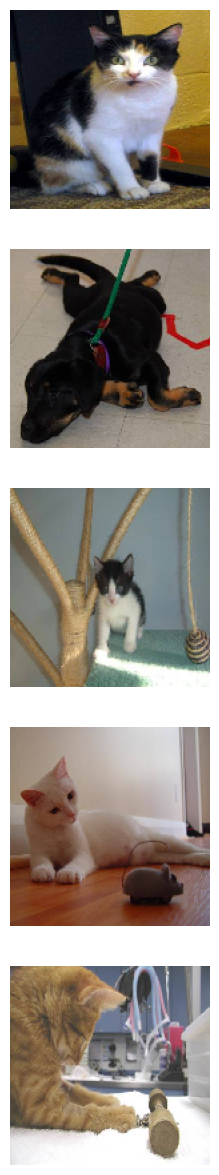

In [ ]:
sample, _ = next(training_data)
plotImages(sample[:5])

The project requires to first use ImageDataGenerator without any modifying parameters, then run the function in cell 4, and then use ImageDataGenerator again, this time with modifying parameters.

An alternate way of doing things would be to add modifying parameters to ImageDataGenerator directly in cell 3 and then skip cells 5 and 6 altogether.

The function in cell 4 can be moved to after cell 9 as well.

Below is cell 5 with modifying parameters added to ImageDataGenerator.

In [ ]:
# 5

training_data_generator = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=0.1,
    rescale=1/255)

Cell 6 is just the new training data produced by the updated ImageDataGenerator.

In [ ]:
# 6

training_data = training_data_generator.flow_from_directory(
    directory = training_directory,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True)

Found 2000 images belonging to 2 classes.



*Here is a sample of the modified training data :*

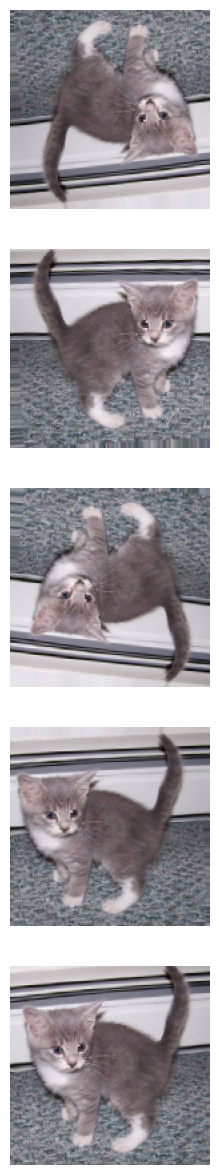

In [ ]:
augmented_images = [training_data[0][0][0] for i in range(5)]
plotImages(augmented_images)

Cell 7 is the CNN itself.

In [ ]:
# 7


model = Sequential([
    Input(shape = (image_width, image_height, 3)),
    Conv2D(32, 2, activation = "relu"),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Conv2D(64, 2, activation = "relu"),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Conv2D(128, 2, activation = "relu"),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation = "relu"),
    Dense(2, activation = "softmax")])

model.compile(
    Adam(learning_rate = 0.0008),
    SparseCategoricalCrossentropy(),
    ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 149, 149, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                        

Cell 8 is where we actually train the CNN.

In [ ]:
# 8

history = model.fit(
    training_data,
    steps_per_epoch = total_training_images // batch_size,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_data,
    validation_steps = total_validation_images // batch_size,
    verbose = 1)

Epoch 1/15
66/66 [==============================] - 87s 1s/step - loss: 2.9449 - accuracy: 0.5985 - val_loss: 1.9434 - val_accuracy: 0.5010
Epoch 2/15
66/66 [==============================] - 84s 1s/step - loss: 1.6095 - accuracy: 0.6299 - val_loss: 3.1737 - val_accuracy: 0.4980
Epoch 3/15
66/66 [==============================] - 82s 1s/step - loss: 1.1084 - accuracy: 0.6487 - val_loss: 4.8463 - val_accuracy: 0.4990
Epoch 4/15
66/66 [==============================] - 91s 1s/step - loss: 0.8104 - accuracy: 0.6914 - val_loss: 2.3874 - val_accuracy: 0.5030
Epoch 5/15
66/66 [==============================] - 82s 1s/step - loss: 0.6149 - accuracy: 0.7137 - val_loss: 1.1361 - val_accuracy: 0.5525
Epoch 6/15
66/66 [==============================] - 89s 1s/step - loss: 0.5654 - accuracy: 0.7234 - val_loss: 0.9159 - val_accuracy: 0.6091
Epoch 7/15
66/66 [==============================] - 81s 1s/step - loss: 0.5129 - accuracy: 0.7548 - val_loss: 1.1618 - val_accuracy: 0.5990
Epoch 8/15
66/66 [==

Cell 9 generates a graph that represents the training and validation accuracy / loss as the model learns.

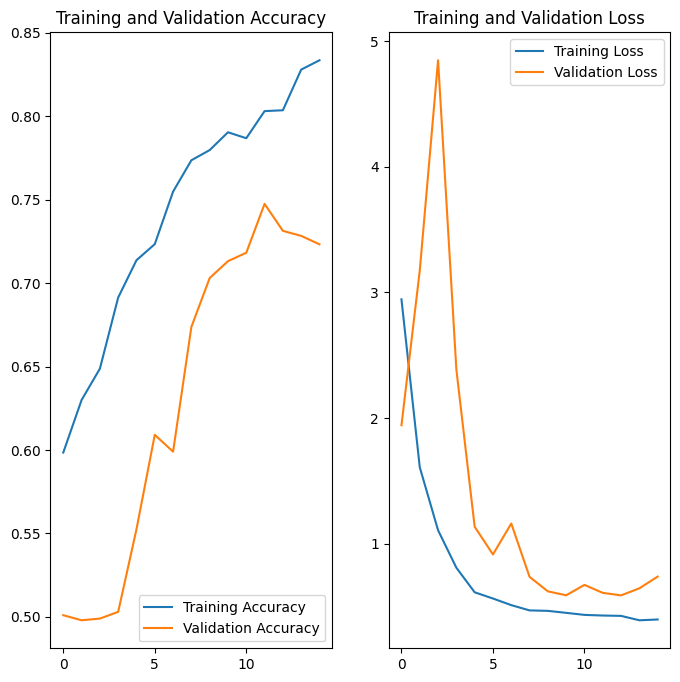

In [ ]:
# 9

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

matplotlib.pyplot.figure(figsize=(8, 8))
matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.plot(epochs_range, acc, label='Training Accuracy')
matplotlib.pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
matplotlib.pyplot.legend(loc='lower right')
matplotlib.pyplot.title('Training and Validation Accuracy')

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.plot(epochs_range, loss, label='Training Loss')
matplotlib.pyplot.plot(epochs_range, val_loss, label='Validation Loss')
matplotlib.pyplot.legend(loc='upper right')
matplotlib.pyplot.title('Training and Validation Loss')
matplotlib.pyplot.show()

Cell 10 is where we test the model and use the plotImages function to check the results.

2/2 [==============================] - 1s 139ms/step


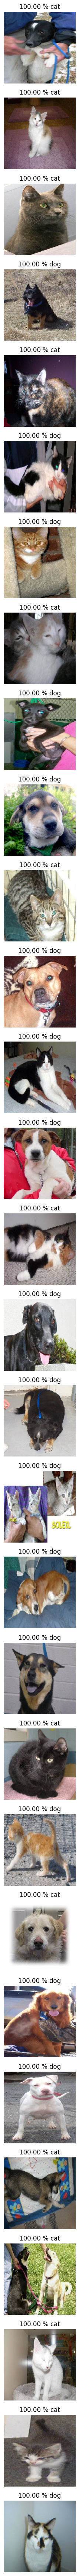

In [ ]:
# 10

test_images, _ = next(testing_data)
probabilities = numpy.argmax(model.predict(testing_data), axis=1)
plotImages(test_images, probabilities = probabilities)

Cell 11 is the project conclusion.

In [ ]:
# 11

# These are the correct results.

answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

# If the answer predicted by the model is the correct result, the ‘correct’ counter increases by 1.

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

# The total is then converted into a percentage.

percentage_identified = (correct / len(answers)) * 100

# The minimum to pass this challenge is 63 %.

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!
